**Import the required libraries**

In [ ]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/SkinCancer/Dataset.zip" > /dev/null

replace Dataset/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Dataset/Test/actinic keratosis/ISIC_0010889.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Defining the path for train and test images**

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Dataset/Test")
data_dir_test = pathlib.Path("/content/Dataset/Train")

# Count the number of image in Train and Test directory

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118
2239


**Data Visualization**

Found 118 files belonging to 9 classes.


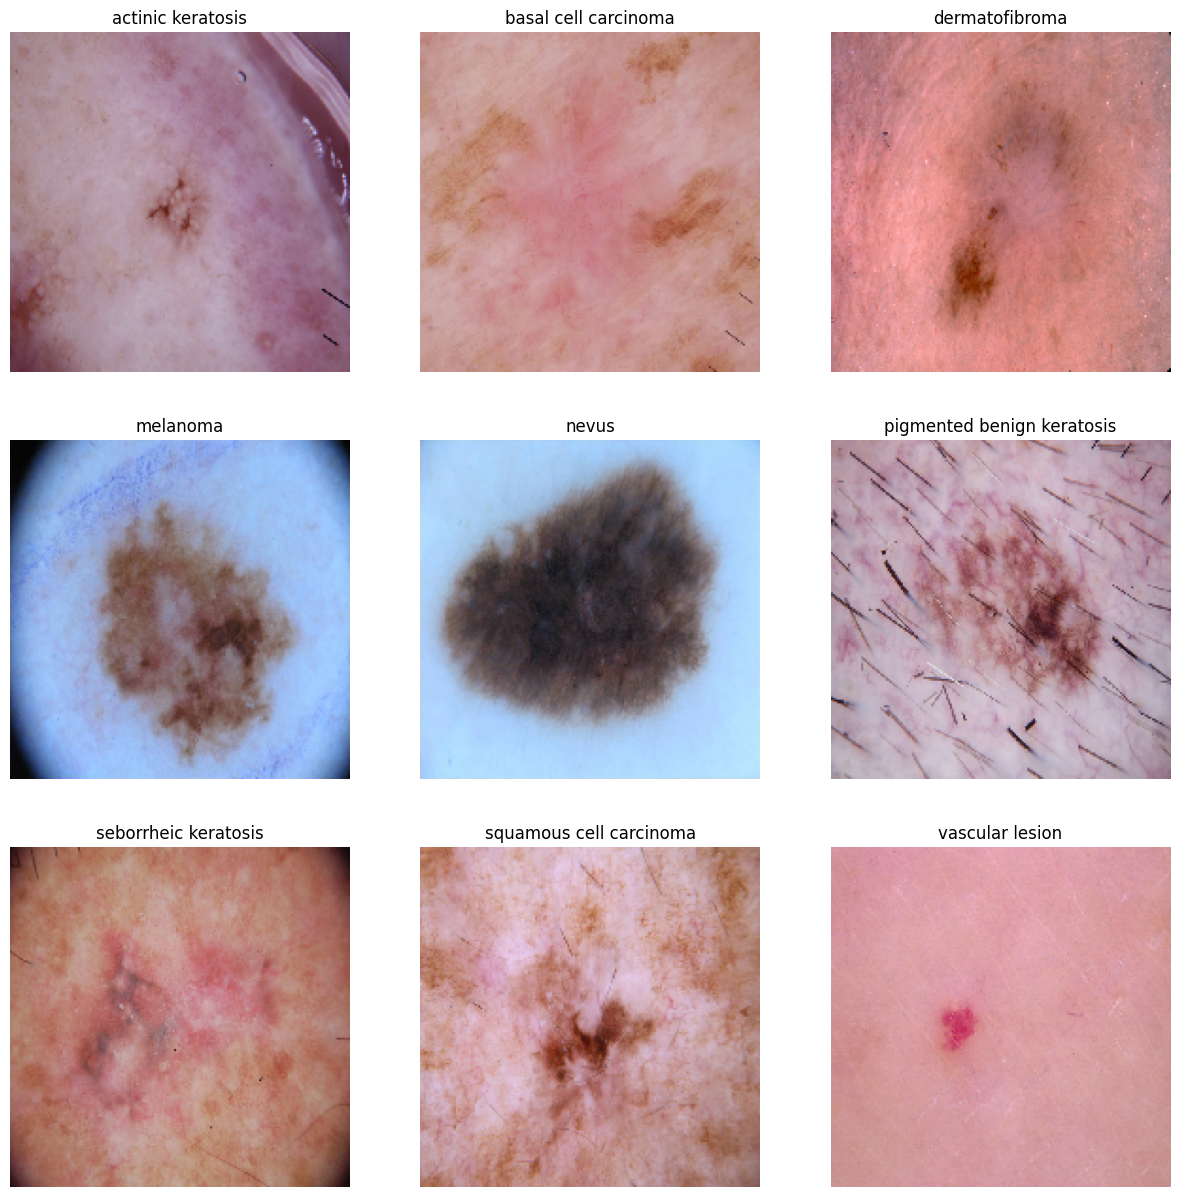

In [ ]:
#Visualize one instance of all the class present in the dataset.

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)
#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [ ]:
import pathlib
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def count_images_in_directory(path):
    """Counts the number of images in a single directory."""
    if path.is_dir():
        return len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    return 0

def class_distribution_count(directory):
    """Counts the number of images in each class directory using threads."""
    # Get the list of subdirectories (classes)
    sub_directories = [path for path in pathlib.Path(directory).iterdir() if path.is_dir()]

    # Use ThreadPoolExecutor to count images in each class concurrently
    with ThreadPoolExecutor() as executor:
        counts = list(executor.map(count_images_in_directory, sub_directories))

    # Extract class names
    class_names = [sub_dir.name for sub_dir in sub_directories]

    # Return a DataFrame with class names and image counts
    return pd.DataFrame(list(zip(class_names, counts)), columns=['Class', 'No. of Image'])

# Call the function and display the DataFrame
df = class_distribution_count(data_dir_train)
df


,Class,No. of Image
0,nevus,16
1,dermatofibroma,16
2,seborrheic keratosis,3
3,actinic keratosis,16
4,squamous cell carcinoma,16
5,vascular lesion,3
6,basal cell carcinoma,16
7,pigmented benign keratosis,16
8,melanoma,16


<Axes: xlabel='No. of Image', ylabel='Class'>

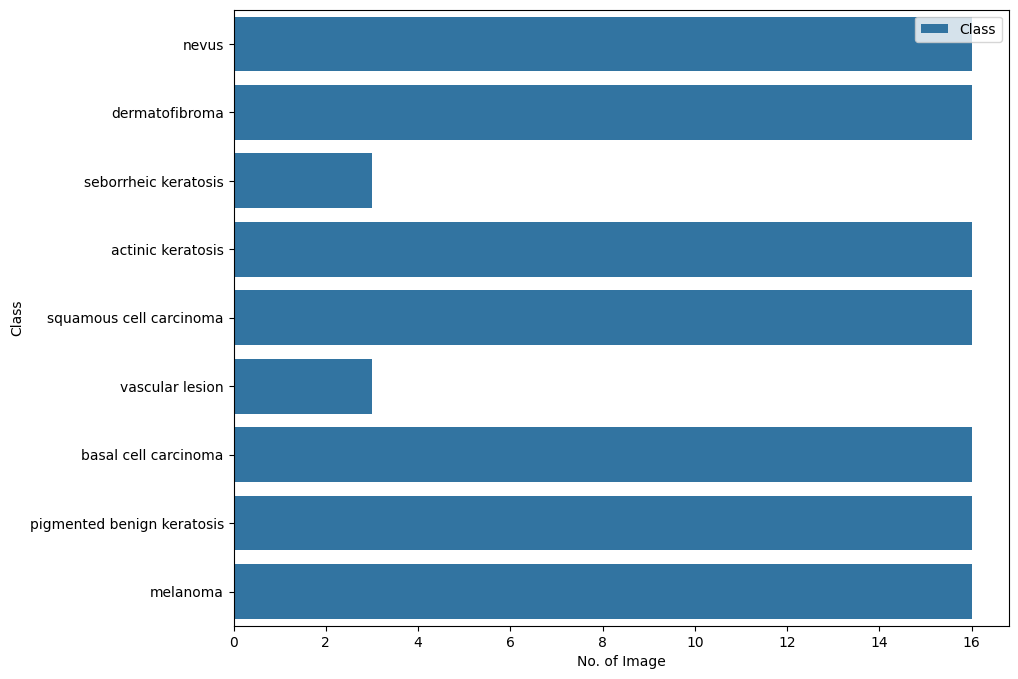

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")


In [ ]:
#install Augmentor
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/Dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 626 image(s) found.
Output directory set to /content/Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x128 at 0x7CF13F3A1240>: 100%|██████████| 500/500 [00:07<00:00, 66.99 Samples/s] 


Initialised with 888 image(s) found.
Output directory set to /content/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x128 at 0x7CF13F23BA90>: 100%|██████████| 500/500 [00:09<00:00, 52.52 Samples/s]


Initialised with 607 image(s) found.
Output directory set to /content/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF13F2631F0>: 100%|██████████| 500/500 [00:07<00:00, 71.18 Samples/s] 


Initialised with 950 image(s) found.
Output directory set to /content/Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CF13F209E10>: 100%|██████████| 500/500 [00:54<00:00,  9.09 Samples/s]


Initialised with 869 image(s) found.
Output directory set to /content/Dataset/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7CF13F229D20>: 100%|██████████| 500/500 [00:45<00:00, 11.00 Samples/s]


Initialised with 974 image(s) found.
Output directory set to /content/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7CF13F3CCD30>: 100%|██████████| 500/500 [00:11<00:00, 41.83 Samples/s]


Initialised with 589 image(s) found.
Output directory set to /content/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7CF13F2603D0>: 100%|██████████| 500/500 [00:07<00:00, 65.16 Samples/s] 


Initialised with 693 image(s) found.
Output directory set to /content/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7CF13F346740>: 100%|██████████| 500/500 [00:09<00:00, 51.63 Samples/s]


Initialised with 651 image(s) found.
Output directory set to /content/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7CF13F3EB820>: 100%|██████████| 500/500 [00:07<00:00, 69.05 Samples/s]


In [ ]:
# Count the total number of images in the training dataset after augmentation
augmented_image_count = len(list(pathlib.Path(path_to_training_dataset).glob('*/*.jpg')))
print(f"Total number of images after augmentation: {augmented_image_count}")

Total number of images after augmentation: 2239


**Model Building**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor
import os

# Path to your dataset
path_to_training_dataset = "/content/Dataset/Train/"

# Enable GPU for TensorFlow
if tf.config.list_physical_devices('GPU'):

else:
    print("CPU is available for data augmentation.")
    # List all class names (subdirectories) in the training dataset
    class_names = [d for d in os.listdir(path_to_training_dataset) if os.path.isdir(os.path.join(path_to_training_dataset, d))]

    # Initialize ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=10,  # Rotation in degrees
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest'  # Fill missing pixels after rotation
    )

    # Function to process data augmentation for a single class
    def augment_class_data(class_name):
        class_path = f"{path_to_training_dataset}/{class_name}"
        generator = datagen.flow_from_directory(
            directory=path_to_training_dataset,
            classes=[class_name],
            target_size=(128, 128),  # Resize images to desired size
            batch_size=32,
            save_to_dir=class_path,  # Save augmented images to the same class folder
            save_format="jpeg"
        )
        # Generate 500 augmented samples per class
        for _ in range(500 // 32 + 1):  # Adjust to match your batch size
            next(generator)
        print(f"Augmentation completed for class: {class_name}")

    # Use ThreadPoolExecutor with a pool size of 8
    with ThreadPoolExecutor(max_workers=8) as executor:
        executor.map(augment_class_data, class_names)

    print("Data augmentation for all classes completed.")

CPU is available for data augmentation.
Found 1589 images belonging to 1 classes.
Found 1607 images belonging to 1 classes.
Found 1888 images belonging to 1 classes.
Found 1869 images belonging to 1 classes.
Found 1626 images belonging to 1 classes.
Found 1693 images belonging to 1 classes.
Found 1974 images belonging to 1 classes.
Found 1651 images belonging to 1 classes.
Augmentation completed for class: vascular lesion
Augmentation completed for class: actinic keratosis
Augmentation completed for class: dermatofibroma
Found 1950 images belonging to 1 classes.
Augmentation completed for class: squamous cell carcinoma
Augmentation completed for class: seborrheic keratosis
Augmentation completed for class: basal cell carcinoma
Augmentation completed for class: pigmented benign keratosis
Augmentation completed for class: nevus
Augmentation completed for class: melanoma
Data augmentation for all classes completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
path_to_training_dataset = "/content/Dataset/Train/"

# Enable GPU for TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for data augmentation.")

    # Load and augment data for each class
    datagen = ImageDataGenerator(
        rotation_range=10,  # Rotation in degrees
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest'  # Fill missing pixels after rotation
    )

    # Create augmented datasets for each class
    for class_name in class_names:
        class_path = f"{path_to_training_dataset}/{class_name}"
        # Use a generator to augment images and save them
        generator = datagen.flow_from_directory(
            directory=path_to_training_dataset,
            classes=[class_name],
            target_size=(128, 128),  # Resize images to desired size
            batch_size=32,
            save_to_dir=class_path,  # Save augmented images to the same class folder
            save_format="jpeg"
        )

        # Generate 500 augmented samples per class
        for _ in range(500 // 32 + 1):  # Adjust to match your batch size
            next(generator)
else:
    print("GPU not detected. Ensure CUDA and drivers are installed.")





GPU not detected. Ensure CUDA and drivers are installed.


In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 118 files belonging to 9 classes.
Using 95 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**CNN Model Architecture**

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer - Changed to use tf.keras.layers.experimental.preprocessing
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

** Vizualizing the model**

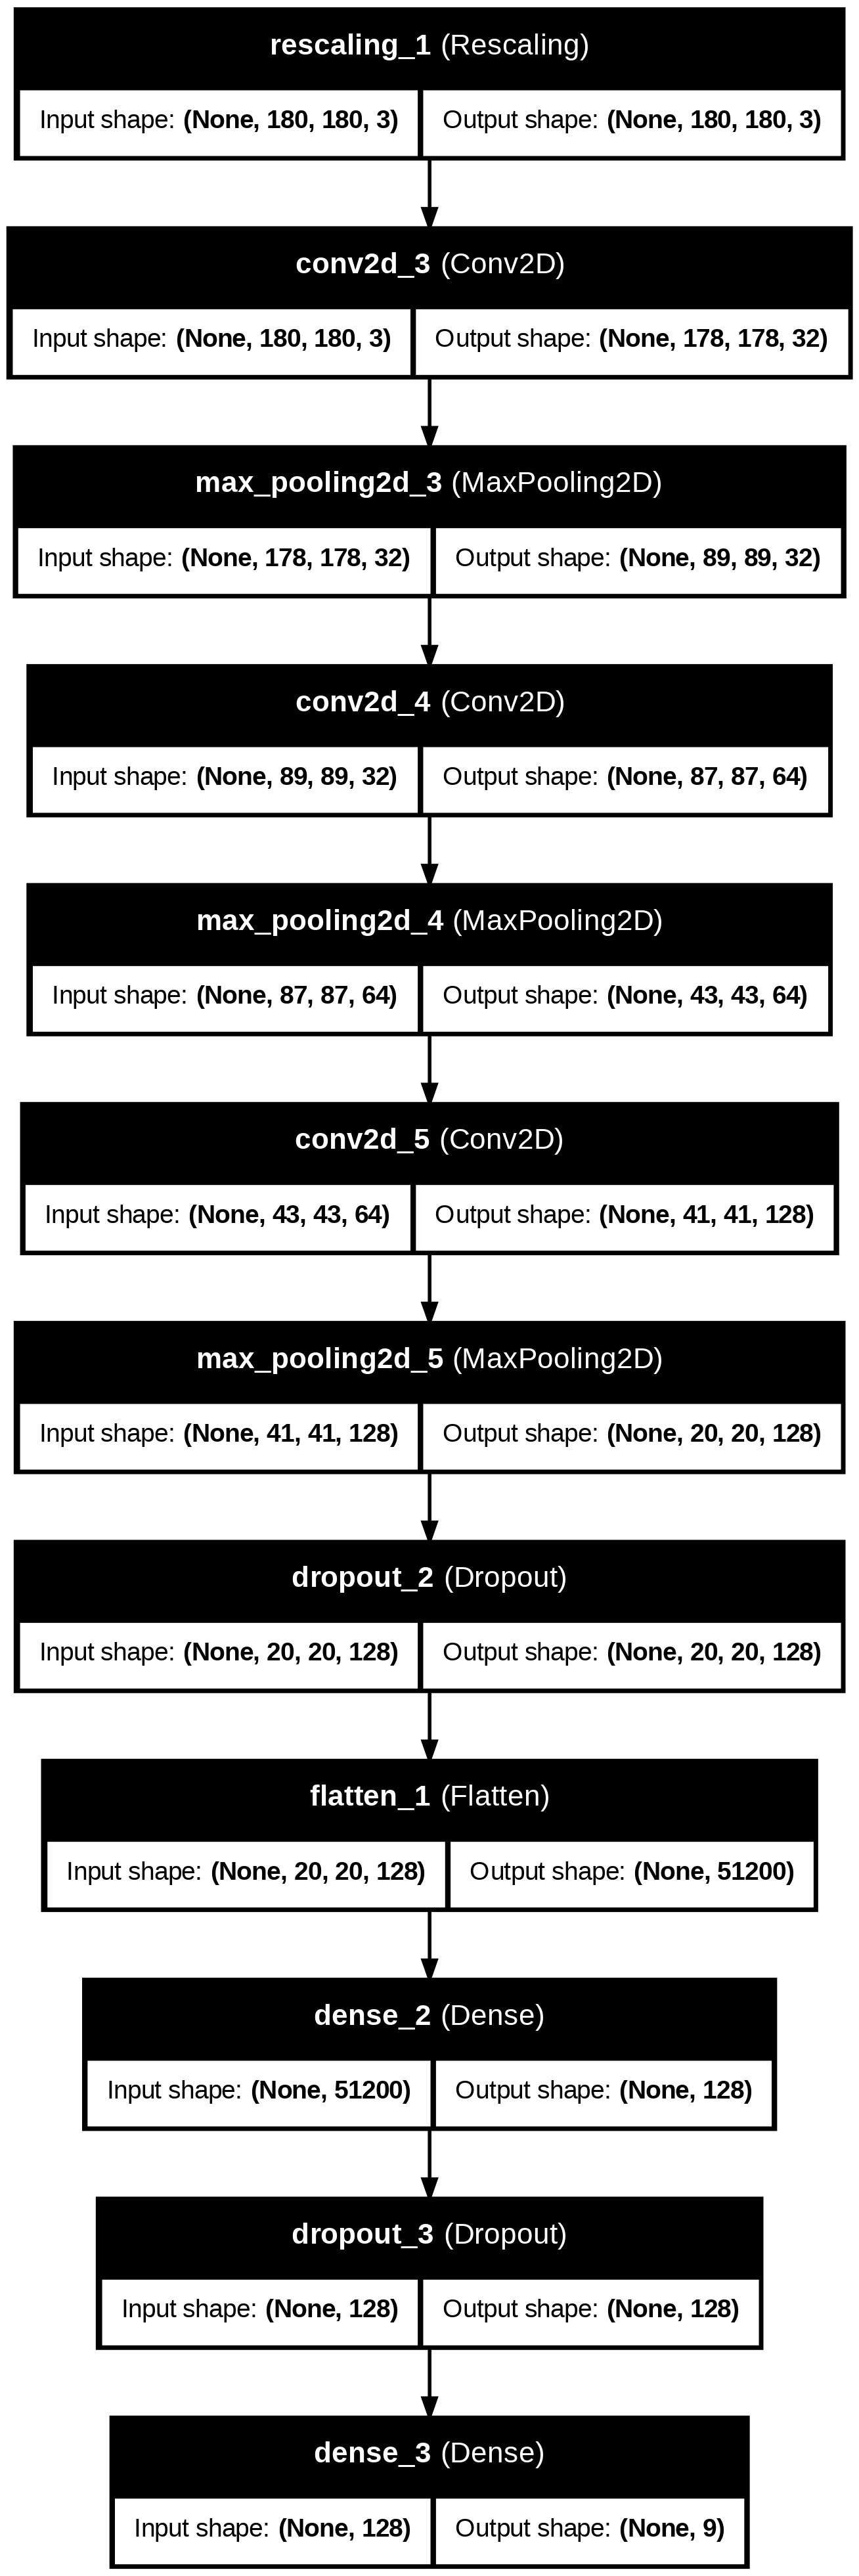

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for training.")
else:
    print("No GPU detected. Please check your runtime settings.")

# Compile the model
# Adam optimization: A stochastic gradient descent method based on adaptive estimation of first-order and second-order moments.
# categorical_crossentropy: A loss function for multi-class classification with two or more output labels.
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# ModelCheckpoint callback: Save model or weights (in a checkpoint file) at intervals to continue training from the saved state.
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping callback: Stop training when the monitored metric stops improving.
earlystop = EarlyStopping(monitor="val_accuracy", patience=15, mode="auto", verbose=1)

# Example of fitting the model (use your own data and parameters)
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint, earlystop])


No GPU detected. Please check your runtime settings.


In [ ]:
# Train the model
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1619 - loss: 2.8439
Epoch 1: val_accuracy improved from -inf to 0.08696, saving model to model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.1530 - loss: 2.9313 - val_accuracy: 0.0870 - val_loss: 3.1023
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1996 - loss: 2.2933
Epoch 2: val_accuracy did not improve from 0.08696
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.1970 - loss: 2.2782 - val_accuracy: 0.0000e+00 - val_loss: 2.2265
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2340 - loss: 2.1083
Epoch 3: val_accuracy did not improve from 0.08696
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2229 - loss: 2.1109 - val_accuracy: 0.0000e+00 - val_loss: 2.4051
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1417 - loss: 2.0530
Epoch 4: val_accuracy did not improve from 0.08696
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1405 - loss: 2.0558 - val_accuracy: 0.0435 - v

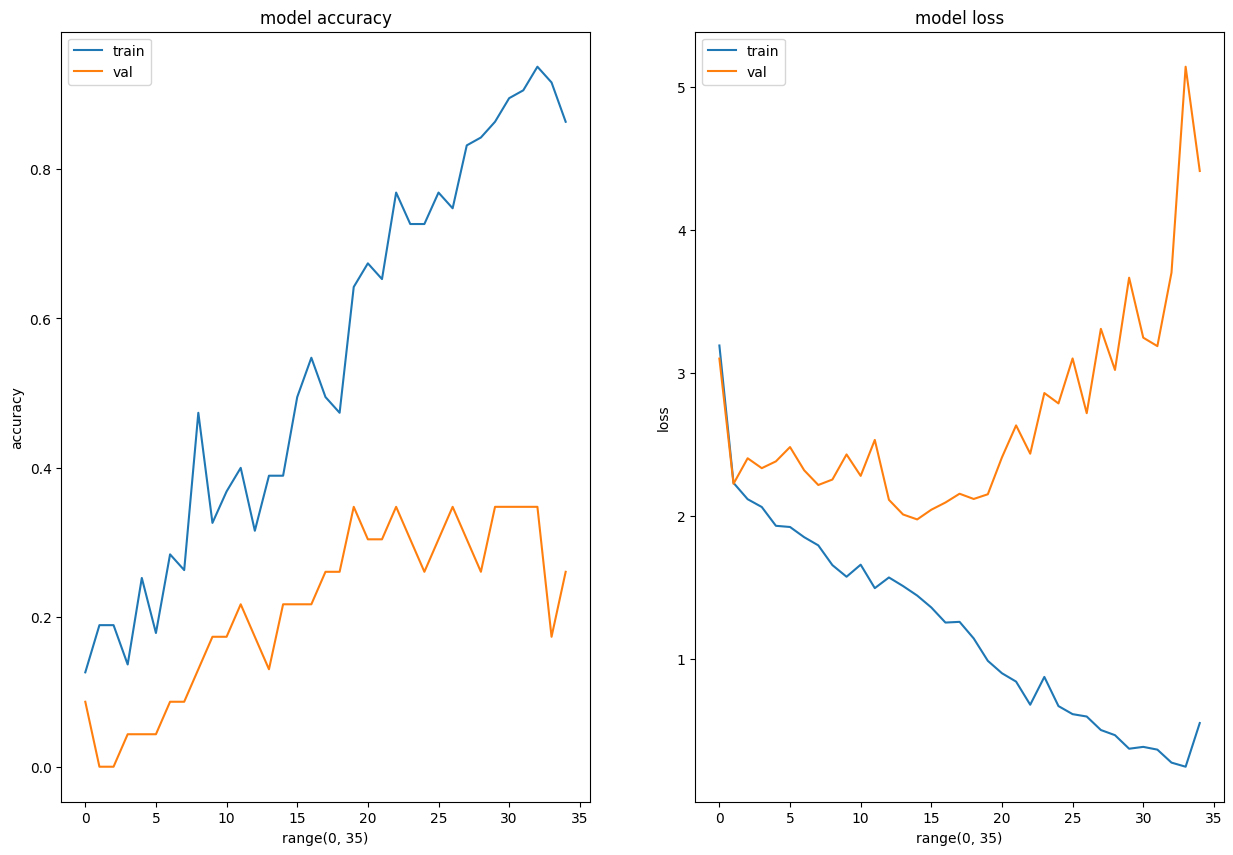

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Actual Class dermatofibroma
Predictive Class dermatofibroma


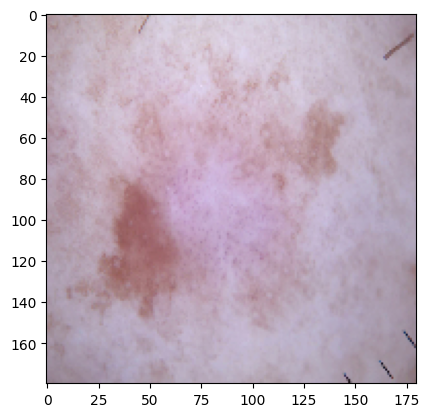

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )